+ **NOTE:** This notebook is trained on Google Colaboratory

## Setting Dataset

In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp '/content/drive/My Drive/Colab Notebooks/kaggle.json' ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [2]:
!kaggle datasets download -d datamunge/sign-language-mnist -p /tmp/

 80% 50.0M/62.6M [00:00<00:00, 60.9MB/s]
100% 62.6M/62.6M [00:00<00:00, 127MB/s] 


## Importing Libraries

In [0]:
import tensorflow as tf

import os
import csv
import zipfile
import random
import numpy as np
import re
import shutil

import matplotlib.image as mpImg
import matplotlib.pyplot as plt
%matplotlib inline

## Analyzing Dataset

In [0]:
local_training_zip = '/tmp/sign-language-mnist.zip'
if zipfile.is_zipfile(local_training_zip):
    zip_ref = zipfile.ZipFile(file=local_training_zip, mode='r')
    zip_ref.extractall('/tmp/')
    zip_ref.close()

In [5]:
def get_data(filename):
    with open(filename) as training_file:
        csv_reader = csv.reader(training_file, delimiter=',')
        first_line = True
        images, labels = [], []
        for row in csv_reader:
            if first_line:
                first_line = False
            else:
                labels.append(row[0])
                images.append(np.array_split(row[1:], 28))
        images = np.array(images).astype('float')
        labels = np.array(labels).astype('float')
    return images, labels

training_images, training_labels = get_data('/tmp/sign_mnist_train/sign_mnist_train.csv')
testing_images, testing_labels = get_data('/tmp/sign_mnist_test/sign_mnist_test.csv')

print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


American Sign Language (ASL) Images


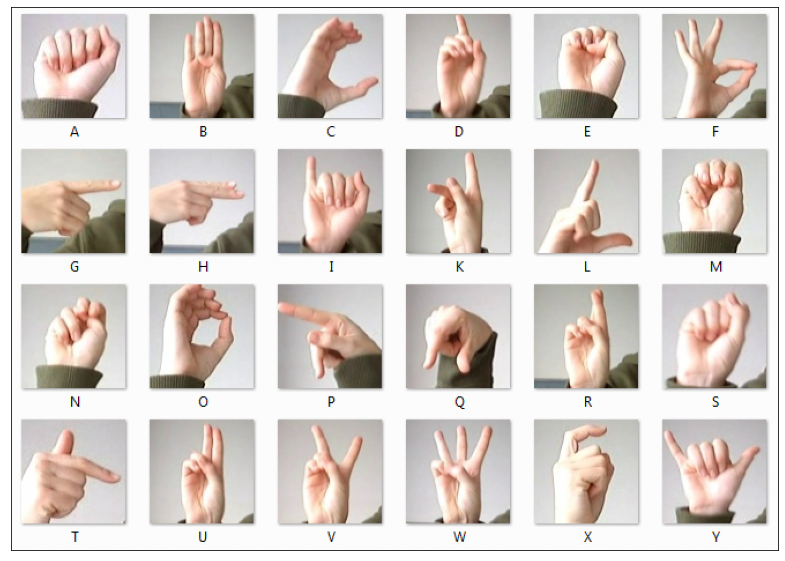

In [6]:
print('American Sign Language (ASL) Images')
plt.figure(figsize=(20, 10))
img = mpImg.imread('/tmp/amer_sign2.png')
plt.imshow(img);
plt.xticks(ticks=[]);
plt.yticks(ticks=[]);

Random 10 images from training set


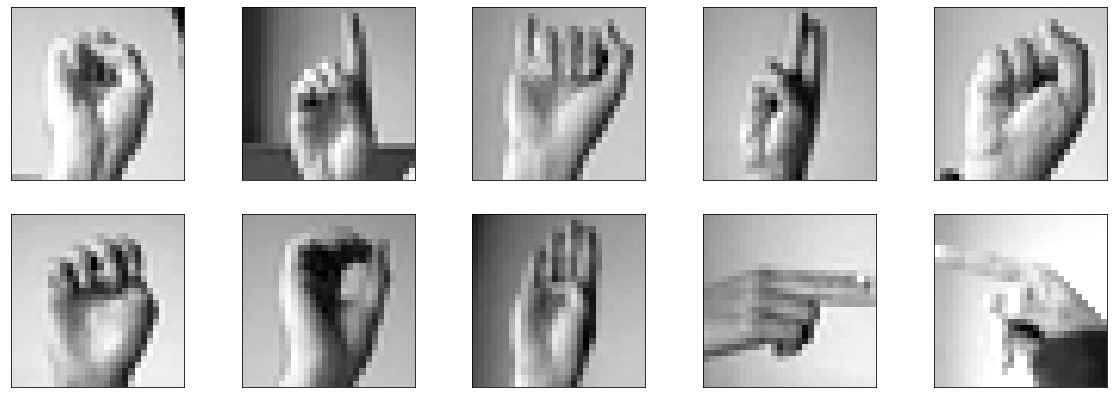

In [7]:
print('Random 10 images from training set')
plt.figure(figsize=(20, 7))
i = 1
while(i<11):
    n = random.randint(0, training_images.shape[0])
    plt.subplot(2, 5, i)
    plt.imshow(training_images[n], 'gray')
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    
    i += 1

In [8]:
set(testing_labels)

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0}

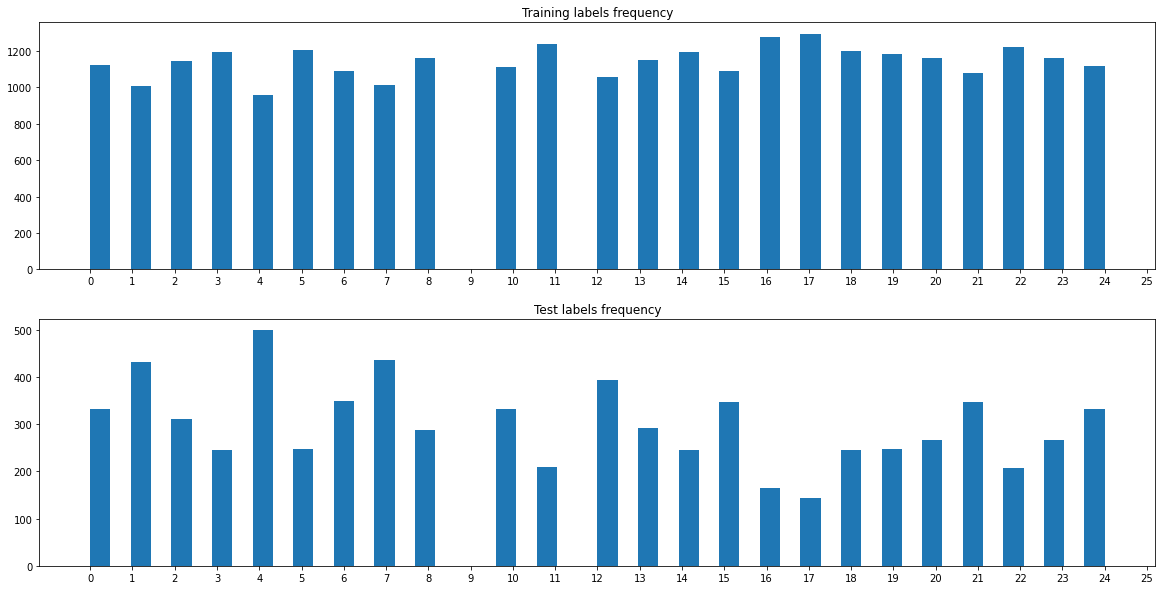

In [9]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.hist(training_labels, bins=50)
plt.title('Training labels frequency')
plt.xticks(range(26))

plt.subplot(2, 1, 2)
plt.hist(testing_labels, bins=50)
plt.title('Test labels frequency')
plt.xticks(range(26));

## Adding one more dimension

In [10]:
training_images = np.expand_dims(training_images, axis=3)
testing_images = np.expand_dims(testing_images, axis=3)

print(training_images.shape)
print(testing_images.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


## Creating the Model

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=26, activation='sigmoid')
])

## Model Summary

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

## Compiling the Model

In [0]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc'])

## Set-up for Generator

In [0]:
# Training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(
    training_images,
    training_labels,
    batch_size=64
)

# Validation data
validate_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
)

validate_generator = validate_datagen.flow(
    testing_images,
    testing_labels,
    batch_size=64
)

## Setting the Callback for the Model

In [0]:
# callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/model/cp.ckpt',
                                                 monitor='val_loss',
                                                 save_weights_only=False,
                                                 save_best_only=True,
                                                 save_freq='epoch',
                                                 verbose=1)

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

## Training the Model

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(training_images)/64,
    validation_data=validate_generator,
    validation_steps=len(testing_images)/64,
    epochs=15,
    callbacks=[cp_callback, early_stopping]
)

Epoch 1/15
429/428 [==============================] - ETA: 0s - loss: 3.0746 - acc: 0.0796
Epoch 00001: val_loss improved from inf to 2.59848, saving model to /content/drive/My Drive/Colab Notebooks/model/cp.ckpt
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model/cp.ckpt/assets
429/428 [==============================] - 11s 25ms/step - loss: 3.0746 - acc: 0.0796 - val_loss: 2.5985 - val_acc: 0.1507
Epoch 2/15
427/428 [============================>.] - ETA: 0s - loss: 2.5343 - acc: 0.1937
Epoch 00002: val_loss improved from 2.59848 to 2.02066, saving model to /content/drive/My Drive/Colab Notebooks/model/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model/cp.ckpt/assets
429/428 [==============================] - 9s 21ms/step - loss: 2.5333 - acc: 0.1940 - val_loss: 2.0207 - val_acc: 0.3031
Epoch 3/15
429/428 [==============================] 

## Analyzing the Trained Model

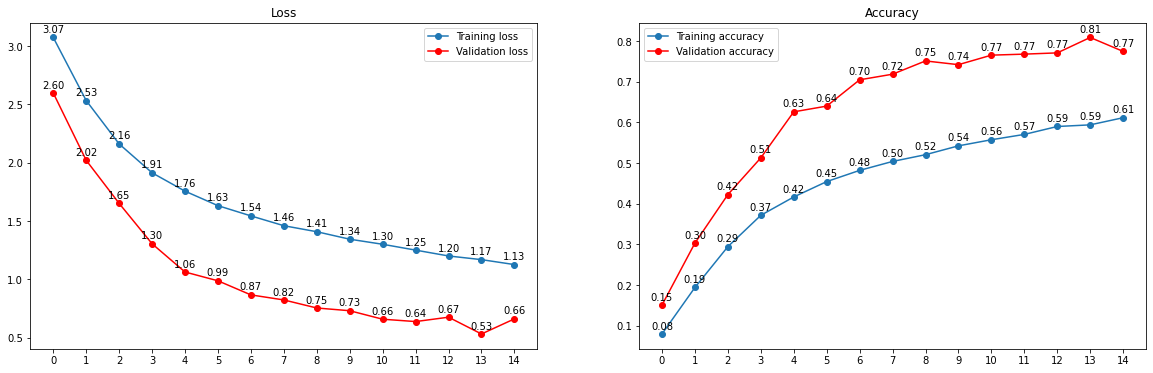

In [18]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='o', label='Training loss')
plt.title('Loss')
plt.legend()
plt.xticks(history.epoch)
for x, y in zip(history.epoch, history.history['loss']):
    label = "{:.2f}".format(y)
    plt.annotate(label,                               # this is the text
                 (x, y),                              # this is the point to label
                 textcoords="offset points",          # how to position the text
                 xytext=(0, 5),                       # distance from text to points (x,y)
                 ha='center')                         # horizontal alignment can be left, right or center

plt.plot(history.history['val_loss'], color='r', marker='o', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.xticks(history.epoch)
for x, y in zip(history.epoch, history.history['val_loss']):
    label = "{:.2f}".format(y)
    plt.annotate(label,                               # this is the text
                 (x, y),                              # this is the point to label
                 textcoords="offset points",          # how to position the text
                 xytext=(0, 5),                       # distance from text to points (x,y)
                 ha='center')                         # horizontal alignment can be left, right or center

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], marker='o', label='Training accuracy')
plt.title('Accuracy')
plt.legend()
plt.xticks(history.epoch)
for x, y in zip(history.epoch, history.history['acc']):
    label = "{:.2f}".format(y)
    plt.annotate(label,                               # this is the text
                 (x, y),                              # this is the point to label
                 textcoords="offset points",          # how to position the text
                 xytext=(0, 5),                       # distance from text to points (x,y)
                 ha='center')                         # horizontal alignment can be left, right or center

plt.plot(history.history['val_acc'], color='r', marker='o', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.xticks(history.epoch)
for x, y in zip(history.epoch, history.history['val_acc']):
    label = "{:.2f}".format(y)
    plt.annotate(label,                               # this is the text
                 (x, y),                              # this is the point to label
                 textcoords="offset points",          # how to position the text
                 xytext=(0, 5),                       # distance from text to points (x,y)
                 ha='center')                         # horizontal alignment can be left, right or center